In [1]:
import torch
import torch.nn as nn

Build a three layer neural network for our task. With PyTorch, we only need to specify the forward layers and we get the backpropgation for free.

In [2]:
class My_Net(nn.Module): 
    def __init__(self, input_size, num_neurons):
        super(My_Net, self).__init__()
        #feed forward layers
        self.layer_1 = nn.Linear(input_size, num_neurons)
        self.layer_2 = nn.Linear(num_neurons, num_neurons)
        self.layer_3 = nn.Linear(num_neurons, num_neurons)
        self.layer_4 = nn.Linear(num_neurons, num_neurons)
        self.layer_5 = nn.Linear(num_neurons, num_neurons)
        self.layer_6 = nn.Linear(num_neurons, num_neurons)
        #self.layer_7 = nn.Linear(num_neurons, num_neurons)
        self.layer_8 = nn.Linear(num_neurons, 6)

        #activations
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid() #Use sigmoid to convert the output into range (0,1)
        
    def forward(self, input_data):
        out = self.layer_1(input_data)
        out = self.relu(out)
        out = self.layer_2(out)
        out = self.relu(out)
        out = self.layer_3(out)
        out = self.relu(out)
        out = self.layer_4(out)
        out = self.relu(out)
        out = self.layer_5(out)
        out = self.relu(out)
        out = self.layer_6(out)
        out = self.relu(out)
        #out = self.layer_7(out)
        #out = self.relu(out)
        out = self.layer_8(out)
        return out

Now we want to load our data into tensors. 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
data = np.array(pd.read_table("stable6.txt", delimiter=' ', header=None, skiprows=7, nrows=32768), dtype=int)
Xdata = data[:,:-1]
Ydata = data[:,-1]-1

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xdata, Ydata, test_size=0.8)

In [6]:
np.shape(X_train)

(6553, 15)

In [7]:
#10 neurons for each hidden layers
net=My_Net(input_size=15, num_neurons=26)

#Standard cross entropy loss for classification tasks
loss=nn.CrossEntropyLoss()

#Define the optimizer. Here we use Adam optimizer.
opt=torch.optim.Adam(net.parameters(),lr=0.0025)
# Set up a scheduler for this larger problem to increase the learning rate after a certain number of epochs
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=50, gamma=0.5)

In [8]:
Xtrain = torch.Tensor(X_train)
Xtest = torch.Tensor(X_test)
ytrain = torch.Tensor(y_train).type(torch.LongTensor)
ytest = torch.Tensor(y_test).type(torch.LongTensor)

Load the data into dataloaders(batches) for stochastic gradient descent.

In [9]:
train = torch.utils.data.TensorDataset(Xtrain, ytrain)
test = torch.utils.data.TensorDataset(Xtest, ytest)

train_loader = torch.utils.data.DataLoader(train, batch_size=256,num_workers=2)
test_loader = torch.utils.data.DataLoader(test, batch_size=256, shuffle=False,num_workers=2)

Define the training and the testing function.

In [10]:
def train_eval(verbose = 1):
    correct = 0
    total = 0
    loss_sum = 0
    num_batches = 0
    for inputs, labels in train_loader:
        outputs = net(inputs)
        predicted = outputs.max(1)[1]
        total += labels.size(0)
        correct += (predicted.int() == labels.int()).sum()
        loss_sum  += loss(outputs,labels).item()
        num_batches += 1

    if verbose:
        print('Train accuracy: %f %%' % (100 * correct.item() / total))
    return loss_sum/num_batches, correct.item() / total

def test_eval(verbose = 1):
    correct = 0
    total = 0
    loss_sum = 0
    num_batches = 0
    for inputs, labels in test_loader:
        outputs = net(inputs)
        predicted = outputs.max(1)[1]
        total += labels.size(0)
        correct += (predicted.int() == labels.int()).sum()
        loss_sum  += loss(outputs,labels).item()
        num_batches += 1

    if verbose:
        print('Test accuracy: %f %%' % (100 * correct.item() / total))
    return loss_sum/num_batches, correct.item() / total

Train the network and report  the training loss/accuracy.

In [11]:
#initialize the network using Xavier initialization.
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)

net.apply(weights_init)

My_Net(
  (layer_1): Linear(in_features=15, out_features=26, bias=True)
  (layer_2): Linear(in_features=26, out_features=26, bias=True)
  (layer_3): Linear(in_features=26, out_features=26, bias=True)
  (layer_4): Linear(in_features=26, out_features=26, bias=True)
  (layer_5): Linear(in_features=26, out_features=26, bias=True)
  (layer_6): Linear(in_features=26, out_features=26, bias=True)
  (layer_8): Linear(in_features=26, out_features=6, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [12]:
import time

epochs=100;
train_loss_store = []
train_acc_store = []
test_loss_store = []
test_acc_store = []

for epoch in range(epochs):
    time1=time.time()
    print('In epoch %i : '%(epoch+1))
    for i, (x,y) in enumerate(train_loader,0):
        #set the gradients to zero initially for each batch
        opt.zero_grad()
        outputs = net(x)
        l=loss(outputs, y)
        l.backward()
        opt.step()
        #break
    
    scheduler.step()
    l_temp, acc_temp = train_eval()
    train_loss_store.append(l_temp)
    train_acc_store.append(acc_temp)

    l_temp, acc_temp = test_eval()
    test_loss_store.append(l_temp)
    test_acc_store.append(acc_temp)

    time2=time.time()
    print("Time lapse: %f secs" %round((time2-time1),2))
    #break

In epoch 1 : 
Train accuracy: 66.900656 %
Test accuracy: 66.576388 %
Time lapse: 0.550000 secs
In epoch 2 : 
Train accuracy: 66.900656 %
Test accuracy: 66.576388 %
Time lapse: 0.450000 secs
In epoch 3 : 
Train accuracy: 66.900656 %
Test accuracy: 66.576388 %
Time lapse: 0.450000 secs
In epoch 4 : 
Train accuracy: 70.166336 %
Test accuracy: 69.406828 %
Time lapse: 0.450000 secs
In epoch 5 : 
Train accuracy: 73.599878 %
Test accuracy: 72.717910 %
Time lapse: 0.450000 secs
In epoch 6 : 
Train accuracy: 78.574699 %
Test accuracy: 77.722678 %
Time lapse: 0.450000 secs
In epoch 7 : 
Train accuracy: 80.848466 %
Test accuracy: 79.362960 %
Time lapse: 0.450000 secs
In epoch 8 : 
Train accuracy: 81.291012 %
Test accuracy: 79.877932 %
Time lapse: 0.440000 secs
In epoch 9 : 
Train accuracy: 82.191363 %
Test accuracy: 80.831585 %
Time lapse: 0.450000 secs
In epoch 10 : 
Train accuracy: 83.213795 %
Test accuracy: 81.472439 %
Time lapse: 0.450000 secs
In epoch 11 : 
Train accuracy: 83.793682 %
Test a

Test accuracy: 89.261873 %
Time lapse: 0.490000 secs
In epoch 87 : 
Train accuracy: 95.818709 %
Test accuracy: 90.299447 %
Time lapse: 0.480000 secs
In epoch 88 : 
Train accuracy: 95.696627 %
Test accuracy: 90.242228 %
Time lapse: 0.480000 secs
In epoch 89 : 
Train accuracy: 94.842057 %
Test accuracy: 89.620446 %
Time lapse: 0.480000 secs
In epoch 90 : 
Train accuracy: 94.933618 %
Test accuracy: 89.723441 %
Time lapse: 0.500000 secs
In epoch 91 : 
Train accuracy: 95.437204 %
Test accuracy: 90.112531 %
Time lapse: 0.490000 secs
In epoch 92 : 
Train accuracy: 95.833969 %
Test accuracy: 90.276559 %
Time lapse: 0.490000 secs
In epoch 93 : 
Train accuracy: 95.818709 %
Test accuracy: 90.226969 %
Time lapse: 0.490000 secs
In epoch 94 : 
Train accuracy: 94.750496 %
Test accuracy: 89.666222 %
Time lapse: 0.490000 secs
In epoch 95 : 
Train accuracy: 95.498245 %
Test accuracy: 90.162121 %
Time lapse: 0.490000 secs
In epoch 96 : 
Train accuracy: 94.796277 %
Test accuracy: 89.837879 %
Time lapse: 0

Visualize the training and testing loss/accuracy.

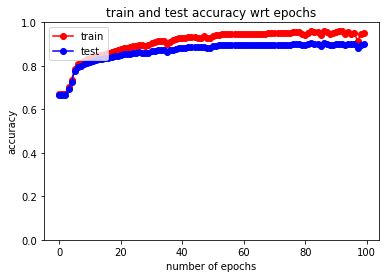

In [13]:
plt.plot(train_acc_store, 'r-o')
plt.plot(test_acc_store, 'b-o')
plt.xlabel('number of epochs')
plt.ylabel('accuracy')
plt.ylim(0,1)
plt.legend(('train','test'), loc='upper left')
plt.title('train and test accuracy wrt epochs')
plt.show()

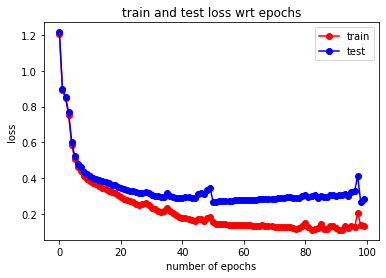

In [14]:
plt.plot(train_loss_store,'r-o')
plt.plot(test_loss_store,'b-o')
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.legend(('train','test'),loc='upper right')
plt.title('train and test loss wrt epochs')
plt.show()